In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_cal_helper as cal
import binary_image_helper as binar
import lane_polynomial_helper as lane
%matplotlib inline

# 1 - Camera calibration

1 - Apply calibration to provided images

In [17]:
#Get object points (same for all images)
nx=9
ny=6
obj=cal.object_points(nx,ny)

#Create the image points and object points list
img_points=[]
obj_points=[]

for fname in glob.glob('camera_cal/calibration*.jpg'):
    #Read image
    img=cv2.imread(fname)
    #Find image points
    ret, corners = cal.find_corners_chessbooard(img,nx,ny,0)
    #Add points to list
    if ret:
        img_points.append(corners)
        obj_points.append(obj)


2- Undistort example image

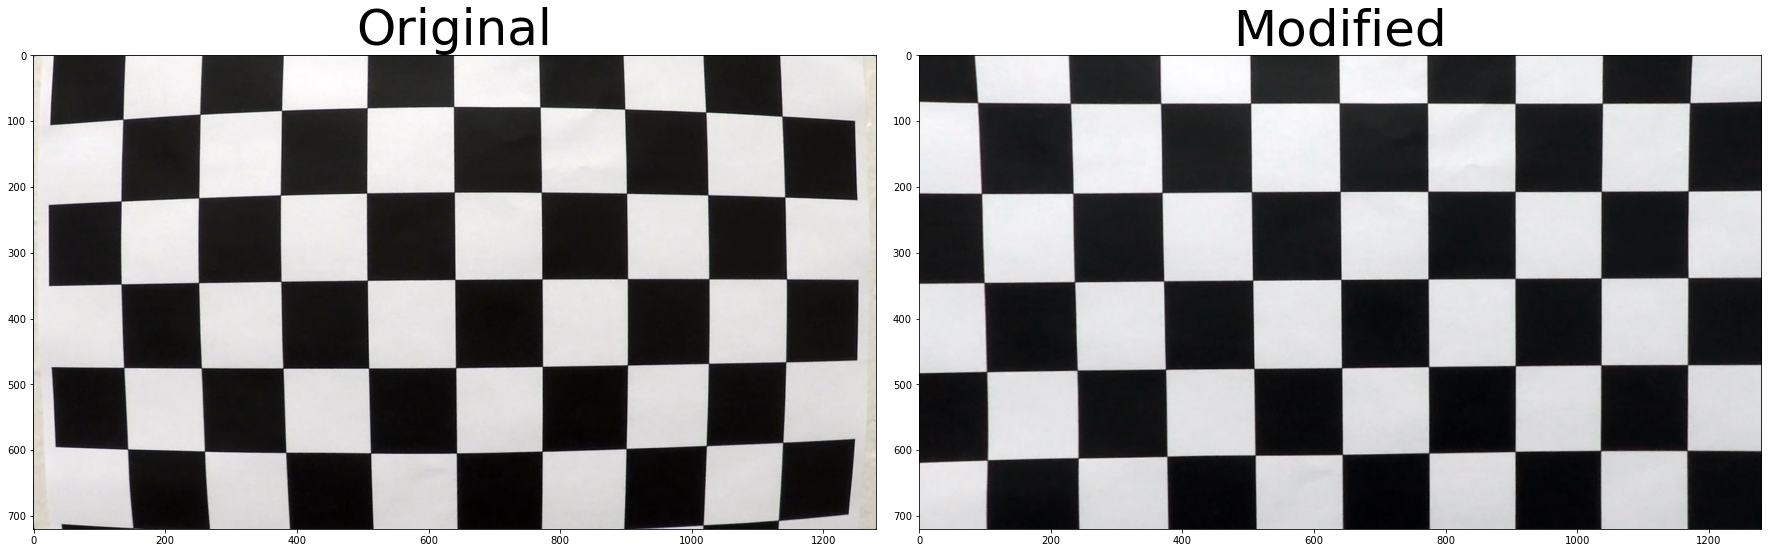

In [18]:
#Select example figure
example_image=cv2.imread('camera_cal/calibration1.jpg')
#Undistort figure
undistorted_example=cal.cal_undistort(example_image, obj_points, img_points)
#Plot and save for markup
cal.compare_images(example_image, undistorted_example, 1, 'images_for_writeup/undistorted_chess_board', 'BGR', 'GRAY')

# 2- Pipeline (test images)

## 2.1 - Apply distortion correction to every image

In [19]:
for fname in glob.glob('test_images/*.jpg'):
    #Read image
    img=cv2.imread(fname)
    #Undistort image
    undistorted=cal.cal_undistort(img, obj_points, img_points)
    #Save images to output folder
    output_file_name='output_images/'+fname[12:-4]+'_undistorted.jpg'
    status = cv2.imwrite(output_file_name,undistorted)
    #Check if everything went well
    if not status:
        print('image not saved')

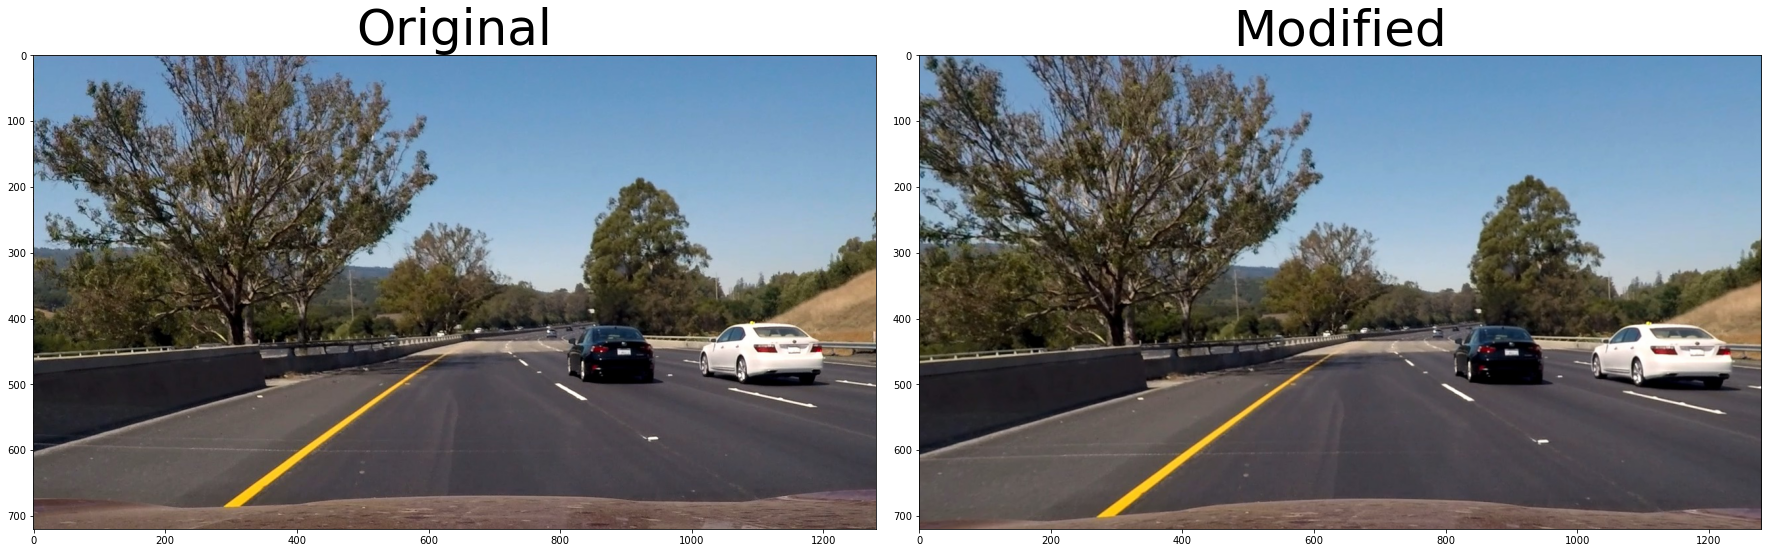

In [20]:
#Example image (last one) for writeup
cal.compare_images(img, undistorted, 1, 'images_for_writeup/distortion_correction_lanes', 'BGR', 'BGR')

## 2.2 - Create binary image for every image

1- Make function for pipeline

In [21]:
def binary_image(image):
    # Obtain binary image based on magnitud of gradient of blue component
    B_channel=image[:,:,0]
    x_binary_B=binar.mag_sobel(B_channel, sobel_kernel=7, thresh=(50, 100))
    # Obtain binary image based on of gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dir_binary= binar.dir_sobel(gray, sobel_kernel=9, thresh=(0.8, 1.2))
    # Obtain binary image based on S channel
    binary_S=binar.HLS_threshold(image, channel='S', thresh=(150, 250))
    #Combine results
    combined = np.zeros_like(gray)
    combined[(binary_S == 1) | ((x_binary_B == 1) & (dir_binary == 1))] = 1
    return combined   

2- Apply to undistorted images

In [22]:
for fname in glob.glob('output_images/*_undistorted.jpg'):
    #Read image
    image=cv2.imread(fname)
    #Get binary image
    binary=binary_image(image)
    #Save images to output folder
    output_file_name='output_images/'+fname[14:-16]+'_binary.jpg'
    plt.imsave(output_file_name, binary, cmap='gray')

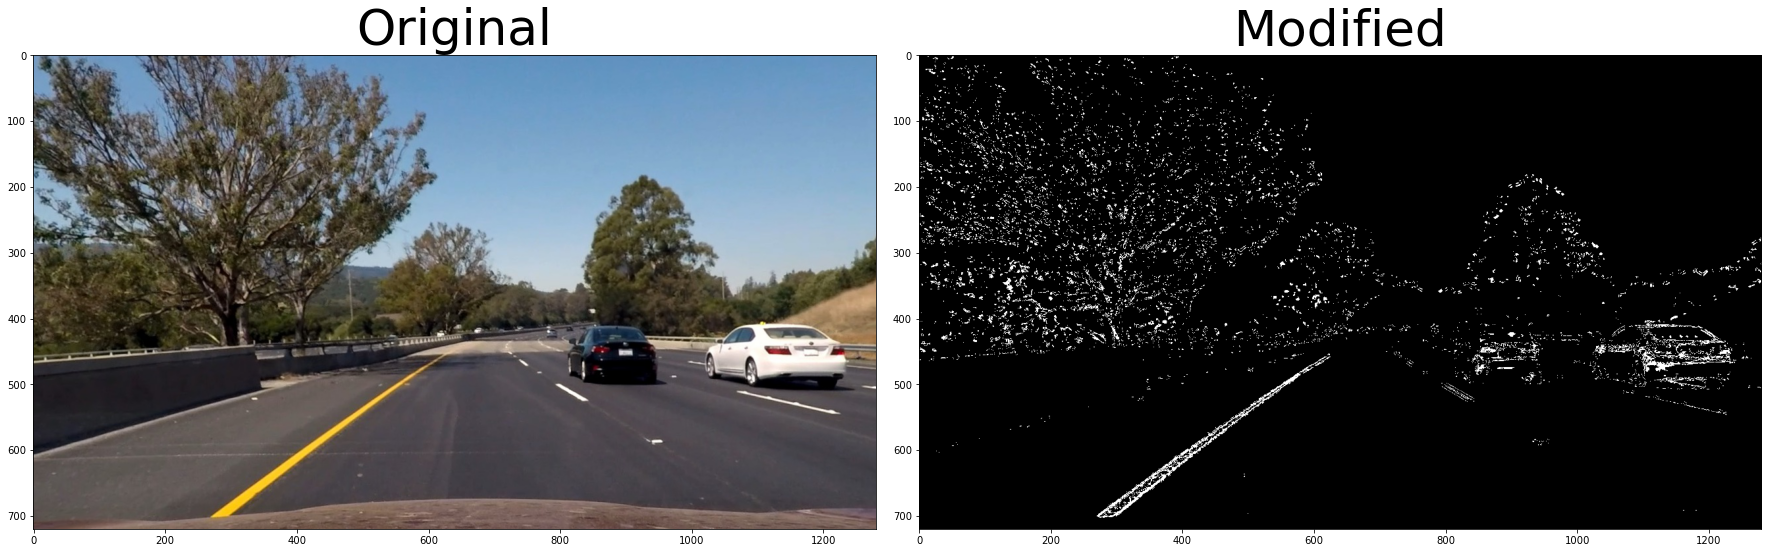

In [23]:
#Example image (last one) for writeup
cal.compare_images(image, binary, 1, 'images_for_writeup/binary_image', 'BGR', 'GRAY')

## 2.3- Perspective transform

1- Create parameters for source and destination points

In [2]:
x_offlow=450
x_offhigh=75

2- Apply perspective transform to binary images

In [26]:
for fname in glob.glob('output_images/*_binary.jpg'):
    #Read image
    image=cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    #Get perspecive tranform
    transformed=cal.pers_transform(image, x_offlow, x_offhigh)
    #Save image to output folder
    output_file_name='output_images/'+fname[14:-11]+'_transformed.jpg'
    plt.imsave(output_file_name, transformed, cmap='gray')

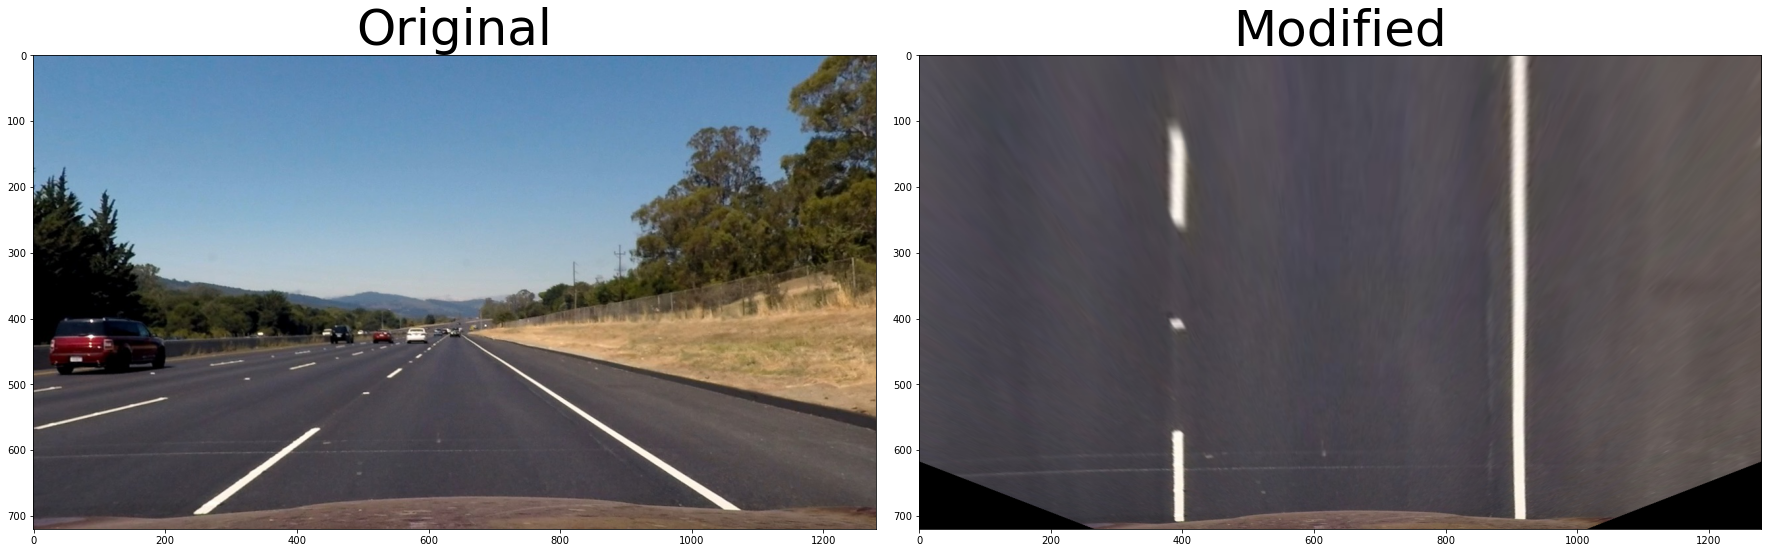

In [27]:
#Example image for writeup
image=cv2.imread('output_images/straight_lines2_undistorted.jpg')
transformed=cal.pers_transform(image, x_offlow, x_offhigh)
cal.compare_images(image, transformed, 1, 'images_for_writeup/transformed_image', 'BGR', 'BGR')

## 2.4- Finding lanes

1 - Set parameters

In [3]:
# Number of sliding windows
nwindows = 9
# Width of the windows +/- margin
margin = 100
# Minimum number of pixels found to recenter window
minpix = 50
# Meters per pixel in x and y direction
ym_per_pix = 30/720
xm_per_pix = 3.7/700

2 - Create pipeline

In [8]:
def finding_lanes(image, binary_top, nwindows, margin, minpix, ym_per_pix, xm_per_pix):
    #Get the lane pixels from the top perspective
    leftx, lefty, rightx, righty, out_img = lane.find_lane_pixels(binary_top, nwindows, margin, minpix)
    #Calculate the lane polynomials
    left_coeff, right_coeff, left_fitx, right_fitx, ploty = lane.fit_polynomial(binary_top.shape, leftx, lefty, rightx, righty)
    #Calculate the radious of curvature and distance to the center
    left_curverad, right_curverad, dist_center= lane.lane_car_parameters(image.shape, left_coeff, right_coeff, left_fitx, right_fitx, ploty, xm_per_pix, ym_per_pix)
    #Update image drawing the lanes
    result_image = lane.lanes_image(image, left_fitx, right_fitx, ploty, x_offlow, x_offhigh)
    #Update image adding text 
    lane.add_lane_par(result_image, left_curverad, right_curverad, dist_center)
    return result_image

3- Apply to images

In [10]:
for fname in glob.glob('output_images/*_transformed.jpg'):
    fname2='output_images/'+fname[14:-16]+'_undistorted.jpg'
    #Read images
    image=cv2.imread(fname2)
    binary_top=cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    #Apply pipeline
    result = finding_lanes(image, binary_top, nwindows, margin, minpix, ym_per_pix, xm_per_pix)
    #Save images to output folder
    output_file_name='output_images/'+fname[14:-16]+'_result.jpg'
    status = cv2.imwrite(output_file_name, result)
    #Check if everything went well
    if not status:
        print('image not saved')

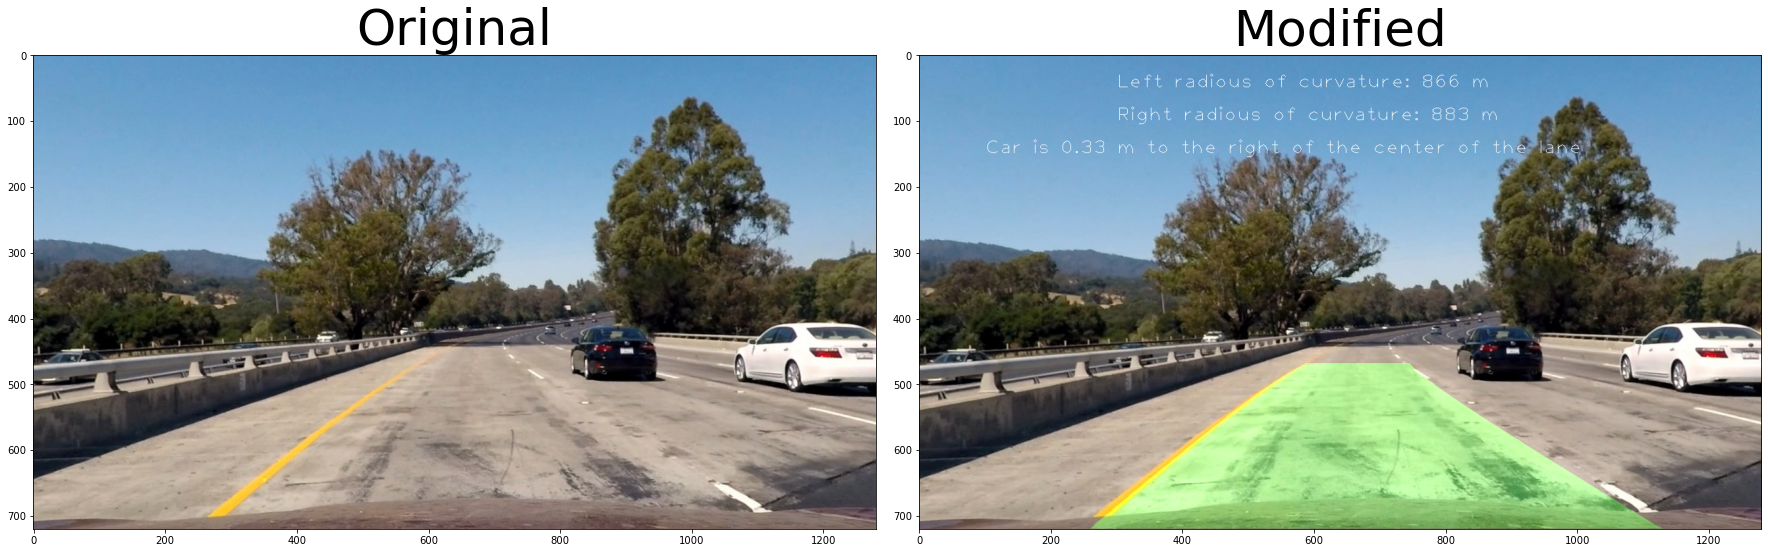

In [14]:
#Example for writeup
image=cv2.imread('output_images/test1_undistorted.jpg')
binary_top=cv2.imread('output_images/test1_transformed.jpg', cv2.IMREAD_GRAYSCALE)
a, b, c, d, out_img = lane.find_lane_pixels(binary_top, nwindows, margin, minpix)
plt.imsave('images_for_writeup/lanes_image.png', out_img)
result = finding_lanes(image, binary_top, nwindows, margin, minpix, ym_per_pix, xm_per_pix)
cal.compare_images(image, result, 1, 'images_for_writeup/result_image', 'BGR', 'BGR')